# NMF

In [1]:
import pandas as pd
import os
import csv

# Identify the working directory and data files
working_directory = "./30-NMF-v2"

# Create the working directory if needed
try:
    os.makedirs(working_directory, exist_ok=True)
except OSError as error:
    print(f"Error creating {working_directory}: {error}")

In [2]:
%pip install --quiet --upgrade nltk gensim

Note: you may need to restart the kernel to use updated packages.


In [3]:
! python -m nltk.downloader --quiet 'all'

/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


In [4]:
# Read the preprocessed data into a dataframe
import pickle

with open("./21-Preprocess-Combined-Data-v2/dataframe.pickle", "rb") as f:
    df = pickle.load(f)

In [5]:
df.shape

(5736, 20)

In [6]:
df.head(4)

,ROW_ID,FOI_TEXT,DEVICE_PROBLEM_CODE,DEVICE_PROBLEM_TEXT,GENERIC_NAME,DEVICE_REPORT_PRODUCT_CODE,UDI-DI,UDI-PUBLIC,DATE_OF_EVENT,REPORTER_OCCUPATION_CODE,REPORT_DATE,EVENT_LOCATION,SOURCE_TYPE,TOKENIZED_TEXT,NOPUNCT_TEXT,NOSTOPWORDS_TEXT,NODIGITS_TEXT,POS_TEXT,LEMMATIZED_TEXT,STEMMED_TEXT
0,1969025,IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...,3283,Wireless Communication Problem,CONTINUOUS GLUCOSE MONITOR,QBJ,,,07/30/2020,000,,I,CONSUMER,"[it, was, reported, that, the, transmitter, lo...","[it, was, reported, that, the, transmitter, lo...","[reported, transmitter, lost, connection, pump...","[reported, transmitter, lost, connection, pump...","[(reported, VBN), (transmitter, NN), (lost, VB...","[report, transmitter, lose, connection, pump, ...","[report, transmitt, lost, connect, pump, great..."
1,1426265,IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...,3283,Wireless Communication Problem,CONTINUOUS GLUCOSE MONITOR,QBJ,00386270000385,00386270000385,06/05/2020,000,,I,CONSUMER,"[it, was, reported, that, signal, loss, over, ...","[it, was, reported, that, signal, loss, over, ...","[reported, signal, loss, one, hour, occurred, ...","[reported, signal, loss, one, hour, occurred, ...","[(reported, VBN), (signal, JJ), (loss, NN), (o...","[report, signal, loss, one, hour, occur, produ...","[report, signal, loss, one, hour, occur, produ..."
2,2609625,IT WAS REPORTED THAT TRANSMITTER FAILED ERROR ...,1435,No Device Output,CONTINUOUS GLUCOSE MONITOR,QBJ,00386270000385,00386270000385,10/05/2020,000,,I,CONSUMER,"[it, was, reported, that, transmitter, failed,...","[it, was, reported, that, transmitter, failed,...","[reported, transmitter, failed, error, occurre...","[reported, transmitter, failed, error, occurre...","[(reported, VBN), (transmitter, NN), (failed, ...","[report, transmitter, fail, error, occur, data...","[report, transmitt, fail, error, occur, data, ..."
3,2813837,IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...,3283,Wireless Communication Problem,CONTINUOUS GLUCOSE MONITOR,QBJ,00386270000385,00386270000385,10/23/2020,000,,I,CONSUMER,"[it, was, reported, that, signal, loss, over, ...","[it, was, reported, that, signal, loss, over, ...","[reported, signal, loss, one, hour, occurred, ...","[reported, signal, loss, one, hour, occurred, ...","[(reported, VBN), (signal, JJ), (loss, NN), (o...","[report, signal, loss, one, hour, occur, revie...","[report, signal, loss, one, hour, occur, revie..."


In [7]:
num_topics = 15  # The number of topics you want to extract
max_topics = 15
num_top_words = 10  # or the number of top words you want to display for each topic

In [8]:
# Step 1: Load text data
text_data = []

for text_list in df["LEMMATIZED_TEXT"]:
    sentence = " ".join(text_list)
    text_data.append(sentence)

# Add the resulting sentences as a new column to the dataframe
df["LEMMATIZED_SENTENCES"] = text_data

In [9]:
len(text_data)

5736

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

# Step 2: Convert text data into a document-term matrix using TF-IDF vectorizer
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(text_data)

In [11]:
# Step 3: Apply NMF with k components
# k = 4
# nmf_model = NMF(n_components=k, random_state=42)
# nmf = nmf_model.fit_transform(tfidf)

In [12]:
num_top_words = 10
coherence_scores = []

for k in range(1, 26):
    nmf_model = NMF(n_components=k, random_state=42, init="nndsvda")
    nmf = nmf_model.fit_transform(tfidf)
    vocab = vectorizer.get_feature_names_out()
    topics = []
    for topic_idx, topic in enumerate(nmf_model.components_):
        top_words = [vocab[i] for i in topic.argsort()[: -num_top_words - 1 : -1]]
        topics.append(top_words)
    texts = df["LEMMATIZED_TEXT"].tolist()
    dictionary = Dictionary(texts)
    topics_ids = [[dictionary.token2id[word] for word in topic] for topic in topics]
    coherence_model = CoherenceModel(
        topics=topics_ids, texts=texts, dictionary=dictionary, coherence="c_v"
    )
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    print(f"k = {k}, Coherence score: {coherence_score}")

k = 1, Coherence score: 0.8242367870330447
k = 2, Coherence score: 0.8762043702033662
k = 3, Coherence score: 0.8976228942418699
k = 4, Coherence score: 0.9120511886876892
k = 5, Coherence score: 0.8773667632979778
k = 6, Coherence score: 0.8867513782665509
k = 7, Coherence score: 0.8731555356206272
k = 8, Coherence score: 0.8803461017782688
k = 9, Coherence score: 0.8492895396283284
k = 10, Coherence score: 0.8952211464228693
k = 11, Coherence score: 0.8695215772958176
k = 12, Coherence score: 0.8586940451115597
k = 13, Coherence score: 0.856328433237104
k = 14, Coherence score: 0.859697521224094
k = 15, Coherence score: 0.8858724416688208
k = 16, Coherence score: 0.8525688971265848
k = 17, Coherence score: 0.846169764417558
k = 18, Coherence score: 0.8602262308575535
k = 19, Coherence score: 0.8441136451029291


/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


k = 20, Coherence score: 0.8400698458802781
k = 21, Coherence score: 0.8731112763649713
k = 22, Coherence score: 0.8584423426116099
k = 23, Coherence score: 0.8486432617085559
k = 24, Coherence score: 0.8293300863764643
k = 25, Coherence score: 0.8295515795029944


Matplotlib is building the font cache; this may take a moment.


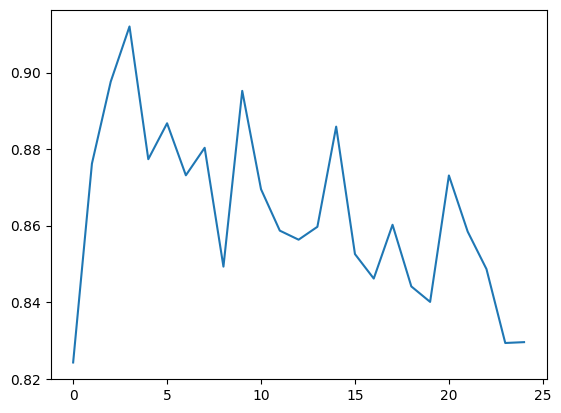

In [13]:
import matplotlib.pyplot as plt
import base64
from io import BytesIO

plt.plot(coherence_scores)

tmpfile = BytesIO()
plt.savefig(tmpfile, format="png")
encoded = base64.b64encode(tmpfile.getvalue()).decode("utf-8")

html = (
    f"<html><head><title>NMF Coherence Score - {working_directory}</title></head><body>"
    + f"<img src='data:image/png;base64,{encoded}'>"
    + "</body></html>"
)

with open(f"{working_directory}/coherence_score.html", "w") as f:
    f.write(html)

plt.show()

In [14]:
selected_k = 10

In [15]:
nmf_model = NMF(n_components=selected_k, random_state=42, init="nndsvda")
nmf = nmf_model.fit_transform(tfidf)
vocab = vectorizer.get_feature_names_out()
topics = []
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = [vocab[i] for i in topic.argsort()[: -num_top_words - 1 : -1]]
    topics.append(top_words)
    selected_words = ", ".join(
        [vocab[i] for i in topic.argsort()[: -num_top_words - 1 : -1]]
    )
    print(f"Topic #{topic_idx}: {selected_words}")

Topic #0: provide, confirmation, evaluation, product, report, data, could, determine, injury, intervention
Topic #1: relevant, become, new, return, supplemental, submit, available, information, evaluation, product
Topic #2: loss, signal, within, window, one, share, log, review, investigation, hour
Topic #3: fail, transmitter, error, evaluate, report, confirm, data, allegation, injury, intervention
Topic #4: read, bg, mgdl, cgm, meter, glucose, reportedly, inaccuracy, continuous, monitor
Topic #5: pump, connection, lose, transmitter, great, issue, additional, replace, patient, resolve
Topic #6: device, receive, however, yet, expect, return, submit, supplemental, perform, evaluation
Topic #7: perform, pass, test, inspection, visual, voltage, external, fail, pair, due
Topic #8: glucose, sensor, value, fall, parkes, grid, zone, insert, b6, abdomen
Topic #9: customer, transmitter, send, replacement, root, receive, additional, failed, month, event


In [16]:
import os
import fnmatch
import subprocess

bucket = "praxis-2023-html-output"
website = f"http://{bucket}.s3-website-us-west-2.amazonaws.com"

# Use the fnmatch module to find all files in the current directory that end in ".html"
file_list = []
for root, dirnames, filenames in os.walk("."):
    for filename in fnmatch.filter(filenames, "*.html"):
        file_list.append(os.path.join(root, filename))

# Sort the file list alphabetically
file_list.sort()

# Create the HTML file and write the header
with open(os.path.join(".", "index.html"), "w") as f:
    f.write(
        """<html>
        <head>
            <title>Praxis 2023 HTML Output</title>
            <style>
                table {
                    border-collapse: collapse;
                    width: 100%;
                }
                th, td {
                    text-align: left;
                    padding: 8px;
                }
                th {
                    background-color: #007bff;
                    color: #fff;
                    font-weight: bold;
                }
                tr:nth-child(even) {
                    background-color: #f2f2f2;
                }
                tr:hover {
                    background-color: #ddd;
                }
            </style>
        </head>
        <body>
            <table>
                <tr><th>Name</th><th>Size</th></tr>\n
    """
    )

    # Loop through each file and add a row to the table
    for file_name in file_list:
        if file_name in ["./index.html"]:
            continue

        file_size = os.path.getsize(file_name)
        f.write(
            f'<tr><td><a href="{website}/{file_name}" target="_blank" rel="noopener noreferrer">{file_name}</a></td><td>{int(file_size / 1048576)} MB</td></tr>\n'
        )

    # Write the footer and close the file
    f.write("</table></body></html>")

command = [
    "aws",
    "s3",
    "sync",
    ".",
    f"s3://{bucket}",
    "--exclude",
    "*",
    "--include",
    "*.html",
    "--no-progress",
]

# Run the command and wait for it to complete
output = subprocess.run(command, capture_output=True, text=True)

# Print the output
print(output.stdout)
print("fin")

upload: ./index.html to s3://praxis-2023-html-output/index.html
upload: 30-NMF-v2/coherence_score.html to s3://praxis-2023-html-output/30-NMF-v2/coherence_score.html

fin
